### Main Page: 

[kaggle](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

### Purpose

We are asking you to predict total sales for every product and store in the next month. 

### Q&A

[number of products only](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/57778)

### Download Data

``` sh
kaggle competitions download -c competitive-data-science-predict-future-sales
```

### Data Field Description

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### File Description
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv - supplemental information about the items categories.
- shops.csv - supplemental information about the shops.

### Evaluation 

Evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

### My Minutes
- item price in testdata could found in train

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.stats import norm, skew
import seaborn as sns
import matplotlib as mpl

In [3]:
%matplotlib inline
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# output each line result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
root_path = '~/.kaggle/competitions/competitive-data-science-predict-future-sales/'
train_file_path = root_path + 'sales_train.csv'
test_file_path = root_path + 'test.csv'

In [5]:
items_file_path = root_path + 'items.csv'
item_categories_file_path = root_path + 'item_categories.csv'
shops_file_path = root_path + 'shops.csv'

In [6]:
dr = pd.read_csv(train_file_path)
dr.head()
test = pd.read_csv(test_file_path)
test.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
shop = pd.read_csv(shops_file_path)
shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
item_category = pd.read_csv(item_categories_file_path)
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
item = pd.read_csv(items_file_path)
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
def join_category(dr):
    # dr get item_category_id by item_id
    return dr.join(item[['item_id', 'item_category_id']].set_index('item_id'), on='item_id')

In [11]:
# add month
train = dr
def get_month(x):
    [d, m, y] = x.split('.')
    return m + '.' + y
train['month'] = train['date'].apply(lambda x: get_month(x))
# train['month'] = pd.to_datetime(train['month'], format='%m.%Y', errors='coerce')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,02.01.2013,0,59,22154,999.00,1.0,01.2013
1,03.01.2013,0,25,2552,899.00,1.0,01.2013
2,05.01.2013,0,25,2552,899.00,-1.0,01.2013
3,06.01.2013,0,25,2554,1709.05,1.0,01.2013
4,15.01.2013,0,25,2555,1099.00,1.0,01.2013


In [12]:
# add item_cnt_month
item_cnt_month = train.groupby(['shop_id', 'item_id', 'month'])['item_cnt_day'].sum().to_frame(name=
                                                                                               'item_cnt_month'
                                                                                              )
item_cnt_month = item_cnt_month.reset_index()
tmp = train.merge(item_cnt_month, how="left", on = ["shop_id", "item_id", "month"])
train_month = tmp
len(train_month)
train_month.head()

2935849

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,01.2013,1.0
1,03.01.2013,0,25,2552,899.00,1.0,01.2013,0.0
2,05.01.2013,0,25,2552,899.00,-1.0,01.2013,0.0
3,06.01.2013,0,25,2554,1709.05,1.0,01.2013,1.0
4,15.01.2013,0,25,2555,1099.00,1.0,01.2013,1.0


In [13]:
# pivot to p_series
p_series = train_month.pivot_table(index=['shop_id','item_id'], columns='month', values='item_cnt_month').fillna(0.0)
p_series = p_series.reset_index()
len(p_series)
p_series.head()

424124

month,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,03.2015,04.2013,04.2014,04.2015,05.2013,05.2014,05.2015,06.2013,06.2014,06.2015,07.2013,07.2014,07.2015,08.2013,08.2014,08.2015,09.2013,09.2014,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
p_series.describe()

month,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,03.2015,04.2013,04.2014,04.2015,05.2013,05.2014,05.2015,06.2013,06.2014,06.2015,07.2013,07.2014,07.2015,08.2013,08.2014,08.2015,09.2013,09.2014,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014
count,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000,424124.000000
mean,31.431223,11458.020213,0.310001,0.275625,0.261648,0.302011,0.258620,0.198522,0.346932,0.271847,0.193373,0.252733,0.227660,0.183501,0.252214,0.230569,0.170457,0.295623,0.229718,0.151168,0.275783,0.215220,0.148982,0.295411,0.242196,0.155801,0.314370,0.233913,0.171749,0.300716,0.253280,0.167536,0.306535,0.277855,0.432284,0.397891
std,16.962064,6133.332458,1.511665,2.792218,3.762653,1.599241,2.682914,1.528047,2.051992,2.917290,1.492460,1.360014,2.891461,3.579918,2.010463,2.301200,2.840769,3.319192,2.487418,1.699408,2.737078,2.181075,1.577261,2.915463,2.358822,1.597581,3.957593,3.269803,4.919659,3.416915,3.427628,4.006454,3.562468,3.688506,4.545389,4.571613
min,0.000000,0.000000,-13.000000,-2.000000,-2.000000,-4.000000,-2.000000,-1.000000,-2.000000,-1.000000,-2.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-2.000000,-2.000000,-1.000000,-2.000000,-5.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-22.000000,-1.000000,-1.000000,-1.000000
25%,18.000000,6244.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,11614.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.000000,16662.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,59.000000,22169.000000,169.000000,899.000000,1127.000000,130.000000,941.000000,300.000000,259.000000,776.000000,291.000000,175.000000,903.000000,1242.000000,504.000000,602.000000,742.000000,766.000000,771.000000,444.000000,799.000000,563.000000,482.000000,820.000000,591.000000,436.000000,950.000000,904.000000,1644.000000,978.000000,1074.000000,2253.000000,989.000000,888.000000,1305.000000,1209.000000


In [15]:
train_month.head()
ip_avg = train_month.groupby(['shop_id', 'item_id'])['item_price'].mean().to_frame(name='item_price').reset_index()

tmp = None

# add item price, cat_id
tmp = p_series.merge(ip_avg, left_on=['shop_id', 'item_id'], right_on=['shop_id', 'item_id'], how='left') \
              .merge(item[['item_id', 'item_category_id']], left_on=['item_id'], right_on=['item_id'], how="left")


# pd.isnull(tmp['item_price']).sum()
len(tmp)
p_series = tmp
p_series.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,01.2013,1.0
1,03.01.2013,0,25,2552,899.00,1.0,01.2013,0.0
2,05.01.2013,0,25,2552,899.00,-1.0,01.2013,0.0
3,06.01.2013,0,25,2554,1709.05,1.0,01.2013,1.0
4,15.01.2013,0,25,2555,1099.00,1.0,01.2013,1.0


424124

,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,03.2015,04.2013,04.2014,04.2015,05.2013,05.2014,05.2015,06.2013,06.2014,06.2015,07.2013,07.2014,07.2015,08.2013,08.2014,08.2015,09.2013,09.2014,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,40
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,37
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0,40
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,37
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,40


### xgboost
### =================================

In [16]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [17]:
p_series.columns

Index(['shop_id', 'item_id', '01.2013', '01.2014', '01.2015', '02.2013',
       '02.2014', '02.2015', '03.2013', '03.2014', '03.2015', '04.2013',
       '04.2014', '04.2015', '05.2013', '05.2014', '05.2015', '06.2013',
       '06.2014', '06.2015', '07.2013', '07.2014', '07.2015', '08.2013',
       '08.2014', '08.2015', '09.2013', '09.2014', '09.2015', '10.2013',
       '10.2014', '10.2015', '11.2013', '11.2014', '12.2013', '12.2014',
       'item_price', 'item_category_id'],
      dtype='object')

In [18]:
p_series[x_columns]

NameError: name 'x_columns' is not defined

In [19]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}
x_columns = ['shop_id', 'item_id', '01.2013', '01.2014', '01.2015', '02.2013',
       '02.2014', '02.2015', '03.2013', '03.2014', '03.2015', '04.2013',
       '04.2014', '04.2015', '05.2013', '05.2014', '05.2015', '06.2013',
       '06.2014', '06.2015', '07.2013', '07.2014', '07.2015', '08.2013',
       '08.2014', '08.2015', '09.2013', '09.2014', '09.2015', '10.2013',
       '10.2014', '11.2013', '11.2014', '12.2013', '12.2014']
y_column = ['10.2015']

progress = dict()
xgbtrain = xgb.DMatrix(p_series[x_columns].values, p_series[y_column].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(p_series[x_columns].values))
rmse = np.sqrt(mean_squared_error(preds, p_series[y_column].values))
print(rmse)

1.27828433195


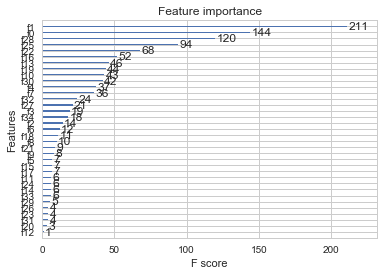

In [20]:
xgb.plot_importance(bst)

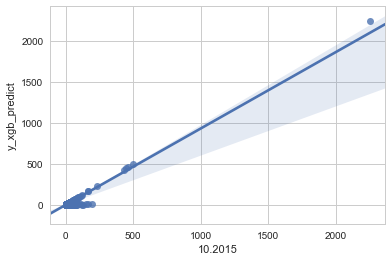

In [615]:
sns.regplot(x=y_column[0], y="y_xgb_predict", data=p_series, color='b')

In [617]:
# train = train[(train.item_price > 0) & (train.item_price < 300000)]
p_series = p_series[(p_series.item_price > 0) & (p_series.item_price < 300000)]
len(p_series)
p_series.head()

424123

,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,...,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id,y_xgb_predict
0,0,30,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,40,0.039235
1,0,31,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,434.0,37,0.065615
2,0,32,6.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.0,40,-0.000514
3,0,33,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347.0,37,0.009230
4,0,35,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.0,40,-0.000514


In [20]:
len(test)
test_series = test.merge(p_series, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
len(test_series)
test_series.head()

214200

214200

,ID,shop_id,item_id,01.2013,01.2014,01.2015,02.2013,02.2014,02.2015,03.2013,03.2014,03.2015,04.2013,04.2014,04.2015,05.2013,05.2014,05.2015,06.2013,06.2014,06.2015,07.2013,07.2014,07.2015,08.2013,08.2014,08.2015,09.2013,09.2014,09.2015,10.2013,10.2014,10.2015,11.2013,11.2014,12.2013,12.2014,item_price,item_category_id
0,0,5,5037,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1633.692308,19.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,865.666667,19.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599.000000,23.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [21]:
test_preds = bst.predict(xgb.DMatrix(test_series[x_columns].values))

In [22]:
# map to [0, 20]
test_preds = list(map(lambda x: min(20,max(x,0)), list(test_preds)))

[i for i in test_preds if i > 20]

[]

### ================================

### Output Result

In [23]:
# Output
submission = pd.DataFrame({'ID':test_series.ID,'item_cnt_month': test_preds })
submission.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.253412
std,61834.358168,0.676087
min,0.000000,0.000000
25%,53549.750000,0.120762
50%,107099.500000,0.138187
75%,160649.250000,0.165632
max,214199.000000,20.000000


In [25]:
# sub['ID'] = sub['ID'].apply(int)
submission.to_csv('/Users/albert_chen/workspace/result.csv',index=False)